# Assignment 2 Notebook
## Regression Model

Root Mean Squared Error: 57.97632116390059
R^2 Score: 0.5495140632944843
Best parameters for ElasticNet: {'alpha': 0.01, 'l1_ratio': 0.9}


Text(50.722222222222214, 0.5, 'alpha')

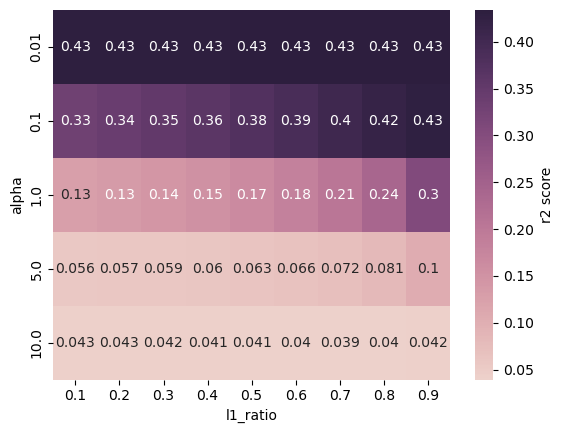

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import root_mean_squared_error, r2_score


# import dataset
heart_disease = pd.read_csv("heart_disease_uci.csv")

# clean data
clean_hd_df = heart_disease.copy()

missing_data = clean_hd_df.isnull().sum() / len(clean_hd_df) # calculate ratio of missing values per column
drop_cols = missing_data[missing_data > 0.3].index # create an index of columns that exceed threshold
clean_hd_df.drop(drop_cols, axis = 1, inplace = True) 

clean_hd_df.dropna(inplace = True)
clean_hd_df.drop_duplicates()

# split into target and features
lin_target = clean_hd_df.copy()[clean_hd_df.columns[5]]
lin_features = clean_hd_df.copy().drop("chol", axis = 1)

for col in lin_features.columns:
    if lin_features[col].dtype == 'object':
        lin_features = pd.concat([lin_features, pd.get_dummies(lin_features[col], prefix = col)], axis = 1)
        lin_features.drop(col, axis = 1, inplace = True)

# split data into training and testing
x_train, x_test, y_train, y_test = train_test_split(lin_features, lin_target, test_size = 0.15, random_state = 27)

# train model
elnet_reg = ElasticNet(alpha = 0.01, l1_ratio = 0.9, max_iter = 5000)
elnet_reg.fit(x_train, y_train)

# predict on test data
y_pred = elnet_reg.predict(x_test)

# evaluate model
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")

##### determine best parameters for alpha and l1 ratio #####

# define parameter grid
param_grid_en = {'alpha' : [0.01, 0.1, 1, 5, 10], 
                 'l1_ratio' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

# perform grid search
grid_search_en = GridSearchCV(ElasticNet(max_iter = 5000), param_grid_en, cv = 5)
grid_search_en.fit(x_train, y_train)

print(f"Best parameters for ElasticNet: {grid_search_en.best_params_}")

param_scores = pd.DataFrame(grid_search_en.cv_results_['mean_test_score'])
param_scores_reshaped = param_scores.values.reshape(5, 9)
en_param_scores = pd.DataFrame(param_scores_reshaped, index = param_grid_en['alpha'], columns = param_grid_en['l1_ratio'])
en_param_ranks = pd.DataFrame(grid_search_en.cv_results_['rank_test_score']).values.reshape(5, 9)

sns.heatmap(en_param_scores, 
            cmap = sns.cubehelix_palette(as_cmap=True), 
            annot = en_param_scores, 
            cbar_kws = {'label' : 'r2 score'}
            )
plt.xlabel('l1_ratio')
plt.ylabel('alpha')


## Classification Model

Accuracy score: 0.8558558558558559
F1 score: 0.8805970149253731


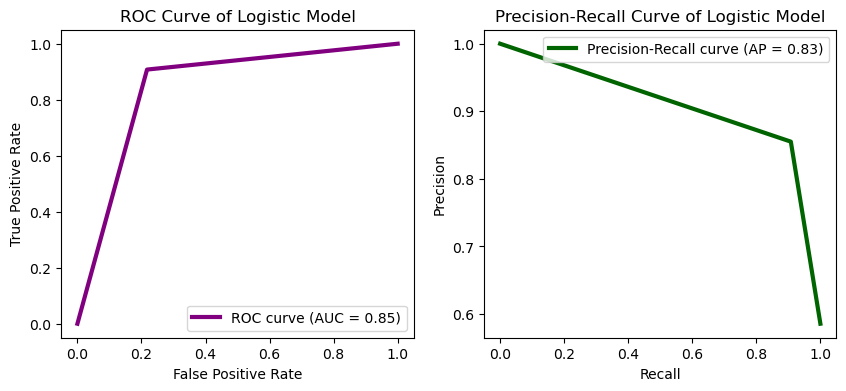

Accuracy score: 0.6216216216216216
F1 score: 0.6818181818181818


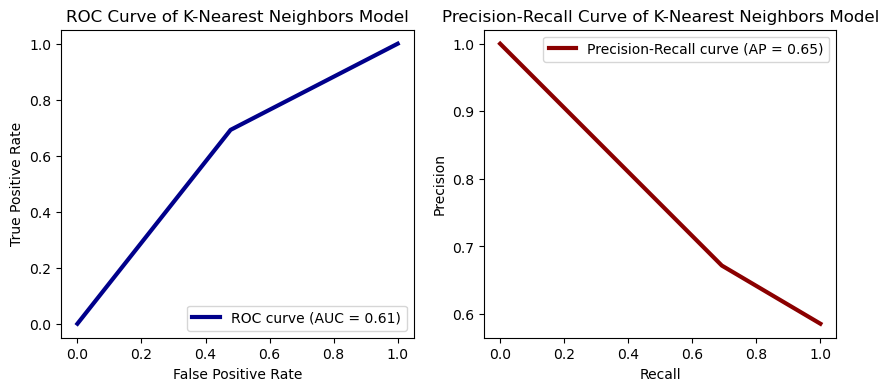

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score, f1_score

clean_hd_df2 = heart_disease.copy()

missing_data2 = clean_hd_df2.isnull().sum() / len(clean_hd_df2) # calculate ratio of missing values per column
drop_cols2 = missing_data2[missing_data2 > 0.3].index # create an index of columns that exceed threshold
clean_hd_df2.drop(drop_cols, axis = 1, inplace = True) 

clean_hd_df2.dropna(inplace = True)
clean_hd_df2.drop_duplicates()

log_target = clean_hd_df2.copy()[clean_hd_df2.columns[11]]
log_features = clean_hd_df2.copy().drop("num", axis = 1)

log_target = log_target.apply(lambda x: 1 if x != 0 else 0)

for col in log_features.columns:
    if log_features[col].dtype == 'object':
        log_features = pd.concat([log_features, pd.get_dummies(log_features[col], prefix = col)], axis = 1)
        log_features.drop(col, axis = 1, inplace = True)

# split data into training and testing
x_train2, x_test2, y_train2, y_test2 = train_test_split(log_features, log_target, test_size = 0.15, random_state = 27)

##### Logistic Model #####
log_reg = LogisticRegression(penalty = 'l1', solver = 'liblinear')
log_reg.fit(x_train2, y_train2)

y_pred2 = log_reg.predict(x_test2)

log_fpr, log_tpr, _ = roc_curve(y_test2, y_pred2)
log_auroc = auc(log_fpr, log_tpr)

log_precision, log_recall, th2 = precision_recall_curve(y_test2, y_pred2)
log_average_precision = average_precision_score(y_test2, y_pred2)

log_acc = accuracy_score(y_test2, y_pred2)
log_f1 = f1_score(y_test2, y_pred2)

print(f'Accuracy score: {log_acc}')
print(f'F1 score: {log_f1}')

log_fig, log_axes = plt.subplots(1, 2, figsize = (10, 4))

log_axes[0].plot(log_fpr, log_tpr, color = 'purple', lw = 3, label = 'ROC curve (AUC = %0.2f)' % log_auroc)
log_axes[0].set_xlabel('False Positive Rate')
log_axes[0].set_ylabel('True Positive Rate')
log_axes[0].set_title('ROC Curve of Logistic Model')
log_axes[0].legend(loc = 'lower right')

log_axes[1].plot(log_recall, log_precision, color = 'darkgreen', lw = 3, label = 'Precision-Recall curve (AP = %0.2f)' % log_average_precision)
log_axes[1].set_xlabel('Recall')
log_axes[1].set_ylabel('Precision')
log_axes[1].set_title('Precision-Recall Curve of Logistic Model')
log_axes[1].legend(loc = 'upper right')

plt.show()

##### K-NN Model #####
knn = KNeighborsClassifier(n_neighbors = 9)
knn.fit(x_train2, y_train2)

y_pred3 = knn.predict(x_test2)

knn_fpr, knn_tpr, _ = roc_curve(y_test2, y_pred3)
knn_auroc = auc(knn_fpr, knn_tpr)

knn_precision, knn_recall, th3 = precision_recall_curve(y_test2, y_pred3)
knn_average_precision = average_precision_score(y_test2, y_pred3)

knn_acc = accuracy_score(y_test2, y_pred3)
knn_f1 = f1_score(y_test2, y_pred3)

print(f'Accuracy score: {knn_acc}')
print(f'F1 score: {knn_f1}')

knn_fig, knn_axes = plt.subplots(1, 2, figsize = (10, 4))

knn_axes[0].plot(knn_fpr, knn_tpr, color = 'darkblue', lw = 3, label = 'ROC curve (AUC = %0.2f)' % knn_auroc)
knn_axes[0].set_xlabel('False Positive Rate')
knn_axes[0].set_ylabel('True Positive Rate')
knn_axes[0].set_title('ROC Curve of K-Nearest Neighbors Model')
knn_axes[0].legend(loc = 'lower right')

knn_axes[1].plot(knn_recall, knn_precision, color = 'darkred', lw = 3, label = 'Precision-Recall curve (AP = %0.2f)' % knn_average_precision)
knn_axes[1].set_xlabel('Recall')
knn_axes[1].set_ylabel('Precision')
knn_axes[1].set_title('Precision-Recall Curve of K-Nearest Neighbors Model')
knn_axes[1].legend(loc = 'upper right')

plt.show()